# Plotting Records
### Part 3 of 3

This notebook follows sequentially from [NOAA-CO-OPS-data](NOAA-CO-OPS-data.ipynb) in which we downloaded the latest data for a particular NOAA [CO-OPS](https://tidesandcurrents.noaa.gov/) weather and tide station. The data record and corresponding metadata were written to file. Here we use those data and calculates several daily and monthly statistics and records. This is done in two steps:

1. **Filter the data**: We do not perform any quality assurance or quality control checks, but we do remove from the records any days missing a specified amount of data and any months missing a specified number of days of data.
2. **Calculate records**:

   - Daily and monthly averages
   - Record high daily and monthly averages<sup>*</sup>
   - Record low daily and monthly averages<sup>*</sup>
   - Average daily and monthly high
   - Lowest daily and monthly high<sup>*</sup>
   - Record daily and monthly high<sup>*</sup>
   - Average daily and monthly low
   - Highest daily and monthly low<sup>*</sup>
   - Record daily and monthly low<sup>*</sup>

Years are also noted for those records marked by an asterisk (*).

### Packages and configurations

First we import the packages we need.

In [1]:
from scipy.optimize import curve_fit
from datetime import datetime as dt
from bokeh.plotting import figure, show, output_file
from bokeh.io import output_notebook
import bokeh.models as bm
# import plotly.graph_objects as go
# import plotly.express as px
# import plotly.io as pio
import pandas as pd
import xarray as xr
import numpy as np
import yaml
import os

# Tell bokeh to display plots in the notebook
output_notebook(hide_banner=True)

By default, Python only displays warnings the first time they are thrown. Ideally, we want a code that does not throw any warnings, but it sometimes takes soem trial and error to resolve the issue being warned about. So, for diagnostic purposes, we'll set the kernel to always display warnings.

In [2]:
import warnings
warnings.filterwarnings('always')

### Functions

Next, we define a number of functions that will come in handy later.

#### Helper functions

In [3]:
def camel(text):
    """Convert 'text' to camel case"""
    s = text.replace(',','').replace("-", " ").replace("_", " ")
    s = s.split()
    if len(text) == 0:
        return text
    return s[0].lower() + ''.join(i.capitalize() for i in s[1:])

def DOY(df):
    """Determine year day out of 366"""
    # Day of year as integer
    df['YearDay'] = df.index.day_of_year.astype(int)
    # Years that are NOT leap years
    leapInd = [not calendar.isleap(i) for i in df.index.year]
    mask = (leapInd) & (df.index.month > 2)
    # Advance by one day everything after February 28 
    df.loc[mask, 'YearDay'] += 1
    return df

def round_down(num, divisor):
    """Round num down to the nearest divisor.
    For example, round_down(45.5, 10) will return 40.
    """
    return num - (num%divisor)

def round_up(num, divisor):
    """Round num up to the nearest divisor.
    For example, round_up(45.5, 10) will return 50.
    """
    return num + (divisor - (num%divisor))

#### Plotting

In [4]:
def cos_fit(data, plot=False):
    """Fit cosine curve to data"""
    X = np.arange(0, len(data))/len(data)

    # Initial parameter values
    guess_freq = 1
    guess_amplitude = 3*np.std(data)/(2**0.5)
    guess_phase = 0
    guess_offset = np.mean(data)
    p0 = [guess_freq, guess_amplitude,
          guess_phase, guess_offset]

    # Function to fit
    def my_cos(x, freq, amplitude, phase, offset):
        return np.cos(x * freq + phase) * amplitude + offset

    # Fit curve to data
    fit = curve_fit(my_cos, X, data, p0=p0)

    if plot:
        fig, ax = plt.subplots(1, 1, figsize=(12,5))

        ax.plot(data, label=data.name)
        ax.plot(fit, color='red', label=f'Cosine fit')

        ax.legend(loc='best')
        plt.show()
    else:
        return my_cos(np.array(X), *fit[0])

In [70]:
def daily_climo(data, var, flood_thresholds, scheme='mg', display=True):
    """Create a daily climatology plot for environmental variable 'var'
    from 'data' using color scheme 'scheme'.
    
    Inputs:
        data: xarray containing climatological stats
        var: str, one of the available environmental variables in 'data'
        flood_threshold: dict containing flood thresholds to add to water
            level plot
        scheme: str specifying which color scheme to use. Options: 'mg'
            for M. Grossi's, 'bm' for B. McNoldy's, or 'cb' to use a
            colorblind scheme
        display: bool, whether to display the plot (default). If False,
            the plot object will be returned instead.
    """

    # Dates for x axis
    df = data.sel(variable=var).to_dataframe().drop('variable', axis=1)
    df['xdates'] = pd.date_range(start='2020-01-01',end='2020-12-31', freq='1D')
    df['Average High Curve'] = cos_fit(df['Average High']).round(1)
    df['Daily Average Curve'] = cos_fit(df['Daily Average']).round(1)
    df['Average Low Curve'] = cos_fit(df['Average Low']).round(1)
    
    # Color dictionary
    colors = dict(
        mg=dict({
            'Record High Year': 'white',
            'Record High': '#d26c6c',
            'Average High': '#dc8d8d',
            'Daily Average': '#F5F5F5',
            'Average Low': '#a2bff4',
            'Record Low': '#74a0ef',
            'Record Low Year': 'white',
            'Plot Light Color': '#D3D3D3'}),
        bm=dict({
            'Record High Year': 'white',
            'Record High': 'orange',
            'Average High': 'orangered',
            'Daily Average': 'gainsboro',
            'Average Low': 'mediumpurple',
            'Record Low': 'lightblue',
            'Record Low Year': 'white',
            'Plot Light Color': 'white'}),
        cb=dict({
            'Record High Year': 'white',
            'Record High': '#d26c6c',
            'Average High': '#dc8d8d',
            'Daily Average': '#F5F5F5',
            'Average Low': '#a2bff4',
            'Record Low': '#74a0ef',
            'Record Low Year': 'white',
            'Plot Light Color': 'white'})
        )

    # Record this year
    thisYear = pd.to_datetime('today').year
    thisYearRecords = (df==thisYear)[['Record High Year', 'Record Low Year']].sum().sum()
    lastYearRecords = (df==thisYear-1)[['Record High Year', 'Record Low Year']].sum().sum()
    df['High Records'] = df['Record High'].where(df['Record High Year'] == thisYear)
    df['Low Records'] = df['Record Low'].where(df['Record Low Year'] == thisYear)
    source = bm.ColumnDataSource(df)
    
    # Create a new plot
    ts_start = dt.strptime(data.attrs[f'{var} data range'][0], '%Y-%m-%d').strftime('%-m/%-d/%Y')
    ts_end = dt.strptime(data.attrs[f'{var} data range'][1], '%Y-%m-%d').strftime('%-m/%-d/%Y')
    p = figure(title='Daily {} records  |  {} - {}\n'.format(var.lower(), ts_start, ts_end).upper()+
                     'As of today, {} {} record highs/lows have been set. '.format(thisYearRecords, var.lower())+
                     'Last year, {} records were set.'.format(lastYearRecords),
               background_fill_color='#404040', border_fill_color='#404040',
               width=1000, height=600, x_axis_type='datetime',
               y_range=(round_down(df['Record Low'].min(), 10), round_up(df['Record High'].max(), 10)),
               tools='pan, wheel_zoom, box_zoom, undo, reset, fullscreen',
               outline_line_color=None, sizing_mode='scale_width')

    # This year record highs
    hr = p.scatter(x='xdates', y='High Records', source=source,
                   name=f'{thisYear} High Record', size=6, color='white')
    # This year record lows
    lr = p.scatter(x='xdates', y='Low Records', source=source,
                   name=f'{thisYear} Low Record', size=6, color='white')
    # Record highs
    rh = p.scatter(x='xdates', y='Record High', source=source,
                   name='Record High', size=2,
                   color=colors[scheme]['Record High'])
    # Average high
    ah = p.line(x='xdates', y='Average High Curve', source=source,
                name='Average High', width=3,
                color=colors[scheme]['Average High'])
    # Daily average
    da = p.line(x='xdates', y='Daily Average Curve', source=source,
                name='Daily Average', width=2,
                color=colors[scheme]['Daily Average'])
    # Average lows
    al = p.line(x='xdates', y='Average Low Curve', source=source,
                name='Average Low', width=3,
                color=colors[scheme]['Average Low'])
    # Record lows
    rl = p.scatter(x='xdates', y='Record Low', source=source,
                   name='Record Low', size=2,
                   color=colors[scheme]['Record Low'],
                   hover_fill_color='white', hover_alpha=0.5)

    # Flood thresholds (water level plot only)
    if var=='Water Level':
        for level, threshold in flood_thresholds.items():
            hline = Span(location=threshold, dimension='width',
                         line_dash=[20,8], line_alpha=0.75,
                         line_color='cadetblue', line_width=2)
            p.renderers.extend([hline])
            mytext = bm.Label(x=pd.to_datetime('2019-12-15'), y=threshold+0.1,
                              text=level.upper(), text_color='cadetblue',
                              text_font_size='8px',
                              text_font='arial narrow')
            p.add_layout(mytext)
    
    # Tools
    crosshair = bm.CrosshairTool(dimensions='height',
                              line_color='grey', line_alpha=0.5)
    hover = bm.HoverTool(mode='vline', renderers=[da],
                      formatters={'@xdates': 'datetime'})
    hover.tooltips = """
        <b> @xdates{{%b %d}} </b> <br>
        Record High: @{{Record High}}{{0.0}} <br>
        Average High: @{{Average High Curve}}{{0.0}} <br>
        Daily Average: @{{Daily Average Curve}}{{0.0}} <br>
        Average Low: @{{Average Low Curve}}{{0.0}} <br>
        Record Low: @{{Record Low}}{{0.0}} <br>
        {} High Record: @{{High Records}}{{0.0}} <br>
        {} Low Record: @{{Low Records}}{{0.0}}
        """.format(thisYear, thisYear)
    p.add_tools(hover, crosshair)
    p.toolbar.autohide = True

    # x-axis
    p.xaxis[0].formatter = bm.DatetimeTickFormatter(months="%b %d")
    p.xaxis[0].ticker.desired_num_ticks = 12
    p.xgrid.grid_line_color = None
    p.xaxis.axis_line_color = 'grey'
    p.xaxis.major_tick_line_color = 'grey'
    
    # y-axis
    p.yaxis.axis_label=f'{var} ({data.attrs[f"{var} units"]})'
    p.yaxis.axis_label_text_color = colors[scheme]['Plot Light Color']
    p.ygrid.grid_line_color = 'grey'
    p.yaxis.axis_line_color = None
    p.yaxis.major_tick_line_color = None
    p.yaxis.minor_tick_line_color = None
    
    # Fonts
    p.title.text_font = 'arial narrow'
    p.title.text_font_size = '16px'
    p.title.text_color = colors[scheme]['Plot Light Color']
    p.xaxis.major_label_text_font = 'arial narrow'
    p.xaxis.major_label_text_color = colors[scheme]['Plot Light Color']
    p.xaxis.major_label_text_font_size = "12px"
    p.yaxis.major_label_text_font = 'arial narrow'
    p.yaxis.axis_label_text_font = 'arial narrow'
    p.yaxis.axis_label_text_font_style = 'normal'
    p.yaxis.major_label_text_color = colors[scheme]['Plot Light Color']    
    p.yaxis.major_label_text_font_size = "12px"
    p.yaxis.axis_label_text_font_size = "12px"

    # Legend
    legend = bm.Legend(items=[
        ('{} Record'.format(thisYear), [hr, lr]),
        ('Record High', [rh]),
        ('Average High', [ah]),
        ('Daily Average', [da]),
        ('Average Low', [al]),
        ('Record Low', [rl])],
                    background_fill_color='#404040', border_line_color=None,
                    label_text_color=colors[scheme]['Plot Light Color'],
                    location='center_right', click_policy='mute')
    p.add_layout(legend, 'right')
    
    if display:
        show(p)
    else:
        return(p)

In [71]:
def monthly_climo(data, var, scheme='mg', display=True):
    """Create a monthly climatology plot for environmental variable 'var'
    from 'data' using color scheme 'scheme'.
    
    Inputs:
        data: xarray containing climatological stats
        var: str, one of the available environmental variables in 'data'
        scheme: str specifying which color scheme to use. Options: 'mg'
            for M. Grossi's, 'bm' for B. McNoldy's, or 'cb' to use a
            colorblind scheme
        display: bool, whether to display the plot (default). If False,
            the plot object will be returned instead.
    """

    # Dates for x axis
    df = data.sel(variable=var).to_dataframe().drop('variable', axis=1).reset_index()
    df['Average High Curve'] = cos_fit(df['Average High']).round(1)
    df['Monthly Average Curve'] = cos_fit(df['Monthly Average']).round(1)
    df['Average Low Curve'] = cos_fit(df['Average Low']).round(1)
    
    # Color dictionary
    colors = dict(
        mg=dict({
            'Record High Year': 'white',
            'Record High': '#d26c6c',
            'Average High': '#dc8d8d',
            'Monthly Average': '#F5F5F5',
            'Average Low': '#a2bff4',
            'Record Low': '#74a0ef',
            'Record Low Year': 'white',
            'Plot Light Color': '#D3D3D3'}),
        bm=dict({
            'Record High Year': 'white',
            'Record High': 'orange',
            'Average High': 'orangered',
            'Monthly Average': 'gainsboro',
            'Average Low': 'mediumpurple',
            'Record Low': 'lightblue',
            'Record Low Year': 'white',
            'Plot Light Color': 'white'}),
        cb=dict({
            'Record High Year': 'white',
            'Record High': '#d26c6c',
            'Average High': '#dc8d8d',
            'Monthly Average': '#F5F5F5',
            'Average Low': '#a2bff4',
            'Record Low': '#74a0ef',
            'Record Low Year': 'white',
            'Plot Light Color': 'white'})
        )

    # Record this year
    thisYear = pd.to_datetime('today').year
    thisYearRecords = (df==thisYear)[['Record High Year', 'Record Low Year']].sum().sum()
    lastYearRecords = (df==thisYear-1)[['Record High Year', 'Record Low Year']].sum().sum()
    df['High Records'] = df['Record High'].where(df['Record High Year'] == thisYear)
    df['Low Records'] = df['Record Low'].where(df['Record Low Year'] == thisYear)
    source = bm.ColumnDataSource(df)
    
    # Create a new plot
    ts_start = dt.strptime(data.attrs[f'{var} data range'][0], '%Y-%m-%d').strftime('%-m/%-d/%Y')
    ts_end = dt.strptime(data.attrs[f'{var} data range'][1], '%Y-%m-%d').strftime('%-m/%-d/%Y')
    p = figure(title='Monthly {} records  |  {} - {}\n'.format(var.lower(), ts_start, ts_end).upper()+
                     'As of today, {} {} record highs/lows have been set. '.format(thisYearRecords, var.lower())+
                     'Last year, {} records were set.'.format(lastYearRecords),
               background_fill_color='#404040', border_fill_color='#404040',
               width=1000, height=600,
               x_range=['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun',
                        'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'],
               y_range=(round_down(df['Record Low'].min(), 10), round_up(df['Record High'].max(), 10)),
               tools='pan, wheel_zoom, box_zoom, undo, reset, fullscreen',
               outline_line_color=None, sizing_mode='scale_width')

    # This year record highs
    hr = p.scatter(x='Month', y='High Records', source=source,
                   name=f'{thisYear} High Record', size=6, color='white')
    # This year record lows
    lr = p.scatter(x='Month', y='Low Records', source=source,
                   name=f'{thisYear} Low Record', size=6, color='white')
    # Record highs
    rh = p.scatter(x='Month', y='Record High', source=source,
                   name='Record High', size=7,
                   color=colors[scheme]['Record High'])
    # Average high
    ah = p.line(x='Month', y='Average High Curve', source=source,
                name='Average High', width=4,
                color=colors[scheme]['Average High'])
    # Monthly average
    ma = p.line(x='Month', y='Monthly Average Curve', source=source,
                name='Monthly Average', width=3,
                color=colors[scheme]['Monthly Average'])
    # Average lows
    al = p.line(x='Month', y='Average Low Curve', source=source,
                name='Average Low', width=4,
                color=colors[scheme]['Average Low'])
    # Record lows
    rl = p.scatter(x='Month', y='Record Low', source=source,
                   name='Record Low', size=7,
                   color=colors[scheme]['Record Low'],
                   hover_fill_color='white', hover_alpha=0.5)
    
    # Tools
    crosshair = bm.CrosshairTool(dimensions='height',
                              line_color='grey', line_alpha=0.5)
    hover = bm.HoverTool(mode='vline', renderers=[ma],
                      formatters={'@xdates': 'datetime'})
    hover.tooltips = """
        <b> @Month </b> <br>
        Record High: @{{Record High}}{{0.0}} <br>
        Average High: @{{Average High Curve}}{{0.0}} <br>
        Daily Average: @{{Daily Average Curve}}{{0.0}} <br>
        Average Low: @{{Average Low Curve}}{{0.0}} <br>
        Record Low: @{{Record Low}}{{0.0}} <br>
        {} High Record: @{{High Records}}{{0.0}} <br>
        {} Low Record: @{{Low Records}}{{0.0}}
        """.format(thisYear, thisYear)
    p.add_tools(hover, crosshair)
    p.toolbar.autohide = True

    # x-axis
    p.xgrid.grid_line_color = None
    p.xaxis.axis_line_color = 'grey'
    p.xaxis.major_tick_line_color = 'grey'
    
    # y-axis
    p.yaxis.axis_label=f'{var} ({data.attrs[f"{var} units"]})'
    p.yaxis.axis_label_text_color = colors[scheme]['Plot Light Color']
    p.ygrid.grid_line_color = 'grey'
    p.yaxis.axis_line_color = None
    p.yaxis.major_tick_line_color = None
    p.yaxis.minor_tick_line_color = None
    
    # Fonts
    p.title.text_font = 'arial narrow'
    p.title.text_font_size = '16px'
    p.title.text_color = colors[scheme]['Plot Light Color']
    p.xaxis.major_label_text_font = 'arial narrow'
    p.xaxis.major_label_text_color = colors[scheme]['Plot Light Color']
    p.xaxis.major_label_text_font_size = "12px"
    p.yaxis.major_label_text_font = 'arial narrow'
    p.yaxis.axis_label_text_font = 'arial narrow'
    p.yaxis.axis_label_text_font_style = 'normal'
    p.yaxis.major_label_text_color = colors[scheme]['Plot Light Color']    
    p.yaxis.major_label_text_font_size = "12px"
    p.yaxis.axis_label_text_font_size = "12px"

    # Legend
    legend = bm.Legend(items=[
        ('{} Record'.format(thisYear), [hr, lr]),
        ('Record High', [rh]),
        ('Average High', [ah]),
        ('Monthly Average', [ma]),
        ('Average Low', [al]),
        ('Record Low', [rl])],
                    background_fill_color='#404040', border_line_color=None,
                    label_text_color=colors[scheme]['Plot Light Color'],
                    location='center_right', click_policy='mute')
    p.add_layout(legend, 'right')
    
    if display:
        show(p)
    else:
        return(p)

In [7]:
import bokeh
bokeh.__version__

'3.4.2'

### Loading data

First we need to load in the data and metadata for the desired station. This will be used to determine the directory from which to load the data. 

As before, `stationname` is the custom human-readable "City, ST" string for the station. Since we are not downloading data, we do not need the NOAA-COOPS station ID number.

In [8]:
stationname = 'Virginia Key, FL'

Derive the local directory name containing for data from the station name. This is the same way the directory was created when the data were downloaded.

In [9]:
dirname = camel(stationname)
outdir = os.path.join(os.getcwd(), dirname)

print(f"Station folder: {dirname}")
print(f"Full directory: {outdir}")

Station folder: virginiaKeyFl
Full directory: /home/climatology/virginiaKeyFl


Next, load the data and metadata.

In [10]:
# Metadata
with open(os.path.join(outdir, 'metadata.yml')) as m:
    meta = yaml.safe_load(m)

# Records
days = xr.load_dataset(os.path.join(outdir, 'statistics-daily.nc'))
mons = xr.load_dataset(os.path.join(outdir, 'statistics-monthly.nc'))

<frozen importlib._bootstrap>:241: RuntimeWarning: numpy.ndarray size changed, may indicate binary incompatibility. Expected 16 from C header, got 96 from PyObject


Water level (tide) plots include local flood thresholds for reference. These are taken from https://water.noaa.gov for each site. Let's create a dictionary of the thresholds to include in those plots for Virginia Key, FL.

In [11]:
floods = {'Major Flood Threshold': 2.5,
          'Moderate Flood Threshold': 1.7,
          'Minor Flood Threshold': 1.3}

Finally, display sample daily and monthly plots for air temperature:

In [97]:
output_notebook(hide_banner=True)

In [99]:
# call create_annular_wedge to create tabs with annular wedges for each metric
daily_tabs = []
monthly_tabs = []
for variable in days['variable'].values:
    daily_tabs.append(bm.TabPanel(child=daily_climo(data=days, var=variable, flood_thresholds=floods, display=False),
                                  title=variable.capitalize()))
    monthly_tabs.append(bm.TabPanel(child=monthly_climo(data=mons, var=variable, display=False),
                                    title=variable.capitalize()))

In [100]:
# display all plots as tabs
daily_plot_tabs = bm.Tabs(tabs=daily_tabs, sizing_mode="scale_width")
monthly_plot_tabs = bm.Tabs(tabs=monthly_tabs, sizing_mode="scale_width")

In [101]:
from bokeh.layouts import layout

In [102]:
layout = layout(
    [
        [daily_plot_tabs, monthly_plot_tabs],
    ],
    sizing_mode="stretch_width",
)

show(layout)

In [57]:
from bokeh.application import Application
from bokeh.application.handlers import FunctionHandler
from bokeh.models import CustomJS, Dropdown

In [60]:
output_notebook()

Loading BokehJS ...

In [61]:
## Create Widgets
# variables = list(days.coords['variable'].values)
variables = [(v, v) for v in days.coords['variable'].values]
dropdown = bm.Dropdown(label="Select a variable to plot", menu=variables, button_type='primary')
dropdown.js_on_event("menu_item_click", CustomJS(code="console.log('dropdown: ' + this.item, this.toString())"))

show(dropdown)

In [ ]:
def update_title(attrname, old, new):
    p.title.text = 'Monthly {} records  |  {} - {}\n'.format(var.lower(), ts_start, ts_end).upper()+
                   'As of today, {} {} record highs/lows have been set. '.format(thisYearRecords, var.lower())+
                   'Last year, {} records were set.'.format(lastYearRecords)

In [43]:
############ START BOILERPLATE ############
#### Interactivity -- BOKEH
from bokeh.io import curdoc, show
from bokeh.layouts import row, Widget
from bokeh.models import ColumnDataSource
from bokeh.models.widgets import Slider, TextInput
from bokeh.io import output_notebook # enables plot interface in J notebook
import numpy as np
# init bokeh

from bokeh.application import Application
from bokeh.application.handlers import FunctionHandler
    
    
output_notebook()
############ END BOILERPLATE ############

# Set up data
N = 200
x = np.linspace(0, 4*np.pi, N)
y = np.sin(x)
source = ColumnDataSource(data=dict(x=x, y=y))

# Set up plot
plot = figure(plot_height=400, plot_width=400, title="my sine wave",
              tools="crosshair,pan,reset,save,wheel_zoom",
              x_range=[0, 4*np.pi], y_range=[-2.5, 2.5])

plot.line('x', 'y', source=source, line_width=3, line_alpha=0.6)

# Set up widgets
text = TextInput(title="title", value='my sine wave')
offset = Slider(title="offset", value=0.0, start=-5.0, end=5.0, step=0.1)
amplitude = Slider(title="amplitude", value=1.0, start=-5.0, end=5.0, step=0.1)
phase = Slider(title="phase", value=0.0, start=0.0, end=2*np.pi)
freq = Slider(title="frequency", value=1.0, start=0.1, end=5.1, step=0.1)

# Set up callbacks
def update_title(attrname, old, new):
    plot.title.text = text.value



def update_data(attrname, old, new):
    # Get the current slider values
    a = amplitude.value
    b = offset.value
    w = phase.value
    k = freq.value

    # Generate the new curve
    x = np.linspace(0, 4*np.pi, N)
    y = a*np.sin(k*x + w) + b

    source.data = dict(x=x, y=y)
    ### I thought I might need a show() here, but it doesn't make a difference if I add one
    # show(layout)

for w in [offset, amplitude, phase, freq]:
    w.on_change('value', update_data)


# Set up layouts and add to document
inputs = widgetbox(text, offset, amplitude, phase, freq)
layout = row(plot,
             widgetbox(text, offset, amplitude, phase, freq))



def modify_doc(doc):
    doc.add_root(row(layout, width=800))
    doc.title = "Sliders"
    text.on_change('value', update_title)
    

handler = FunctionHandler(modify_doc)
app = Application(handler)
show(app)

ImportError: cannot import name 'Widget' from 'bokeh.layouts' (/opt/conda/lib/python3.11/site-packages/bokeh/layouts.py)

In [12]:
daily_climo(data=days, var='Air Temperature', flood_thresholds=floods, scheme='mg')

In [12]:
monthly_climo(data=mons, var='Air Temperature', scheme='mg')

***

An early version of this plotting routine used the `plotly` library instead of `bokeh`. While the plots were rendered fine in a Jupyter Notebook, a known issue with Plotly and Quarto prevented them from rendering properly in Quarto dashboards. The earlier version of the `daily_climo()` function is preserved here.

In [53]:
def daily_climo(data, var, scheme='mg'):
    """Create a daily climatology plot for environmental variable 'var'
    from 'data'.
    
    Inputs:
        data: xarray containing climatological stats
        var: str, one of the available environmental variables in 'data'
        scheme: str, either 'mg' or 'bm' specifying whether to use M. Grossi's
            color scheme or B. McNoldy's
        show: Bool, display the plot to screen instead of saving to file
    """

    # Dates for x axis
    xdates = pd.date_range(start='2020-01-01',end='2020-12-31', freq='1D')
    df = data.sel(variable=var)
    
    # Color dictionary
    colors = dict(
        mg=dict({
            'Record High Year': 'white',
            'Record High': '#d26c6c',
            'Average High': '#dc8d8d',
            'Daily Average': '#F5F5F5',
            'Average Low': '#a2bff4',
            'Record Low': '#74a0ef',
            'Record Low Year': 'white'}),
        bm=dict({
            'Record High Year': 'white',
            'Record High': 'orange',
            'Average High': 'red',
            'Daily Average': 'grey',
            'Average Low': 'purple',
            'Record Low': 'white'}        
        ))
    
    # Create figure
    fig = go.Figure()

    # Record highs
    # High records this year
    thisYear = pd.to_datetime('today').year
    thisYearRecords = (df==thisYear).to_dataframe().drop('variable', axis=1)[['Record High Year', 'Record Low Year']].sum().sum()
    lastYearRecords = (df==thisYear-1).to_dataframe().drop('variable', axis=1)[['Record High Year', 'Record Low Year']].sum().sum()
    highRecords = df['Record High'].where(df['Record High Year'] == thisYear).to_dataframe()['Record High']
    highRecords.index = pd.to_datetime(highRecords.index+'-2020')
    lowRecords = df['Record Low'].where(df['Record Low Year'] == thisYear).to_dataframe()['Record Low']
    lowRecords.index = pd.to_datetime(lowRecords.index+'-2020')
    
    first_time = dt.strptime(df.attrs[f'{var} data range'][0], '%Y-%m-%d').strftime('%-m/%-d/%Y')
    last_time = dt.strptime(df.attrs[f'{var} data range'][1], '%Y-%m-%d').strftime('%-m/%-d/%Y')
    fig.add_trace(
    go.Scatter(
        x=highRecords.index, y=highRecords.values,
        name=f'{pd.to_datetime("today").year} Record'.upper(),
        mode='markers',
        marker=dict(size=6, color='white'),
        hovertext=[f'{thisYear} Record: {i}' if not pd.isnull(i) else '' for i in highRecords.values],
        hoverinfo='text'
    ))
    fig.add_trace(
    go.Scatter(
        x=lowRecords.index, y=lowRecords.values,
        name='Low Record',
        mode='markers',
        marker=dict(size=6, color='white'),
        hoverinfo='none'
    ))
    fig.add_trace(
    go.Scatter(
        x=xdates, y=df['Record High'],
        name='Record High'.upper(),
        mode='markers',
        marker=dict(size=3, color=colors[scheme]['Record High'])
    ))
    # Average highs
    fig.add_trace(
    go.Scatter(
        x=xdates, y=cos_fit(df['Average High']).round(1),
        name='Average High'.upper(),
        marker=dict(size=3, color=colors[scheme]['Average High'])
    ))
    # Daily average
    fig.add_trace(
    go.Scatter(
        x=xdates, y=cos_fit(df['Daily Average']).round(1),
        name='Daily Average'.upper(),
        marker=dict(size=3, color=colors[scheme]['Daily Average'])
    ))
    # Average lows
    fig.add_trace(
    go.Scatter(
        x=xdates,
        y=cos_fit(df['Average Low']).round(1),
        name='Average Low'.upper(),
        marker=dict(size=3, color=colors[scheme]['Average Low'])
    ))
    # Record lows
    fig.add_trace(
    go.Scatter(
        x=xdates, y=df['Record Low'],
        name='Record Low'.upper(),
        mode='markers',
        marker=dict(size=3, color=colors[scheme]['Record Low'])
    ))
    # Hover box
    fig.update_traces(
        hoverlabel = dict(bordercolor='white')
    )
    # Plot settings
    fig.update_layout(
        template='plotly_dark',
        paper_bgcolor='#404040',
        plot_bgcolor='#404040',
        height=600, width=1000,
        title=dict(text='Daily {} records'.format(var.lower())+
                        '<br><sup>{}-{}</sup>'.format(first_time, last_time)+
                        '<br><sup>As of today, <b>{}</b> {} record highs/lows have been set. Last year, {} records were set.</sup>'.format(
                            thisYearRecords, var.lower(), lastYearRecords
                        ),
                  font=dict(size=20)),
        yaxis = dict(title=f'{var} ({data.attrs[f"{var} units"]})',
                     showgrid=True, gridcolor='grey'),
        xaxis = dict(showgrid=False, showspikes=True,
                     dtick='M1', tickformat='%b %d'),
        hovermode='x unified',
        legend=dict(itemsizing='constant'),
        hoverlabel=dict(font_size=12)
    )
    for trace in fig['data']: 
        if trace['name'] == 'Low Record':
            trace['showlegend'] = False
    fig.show()

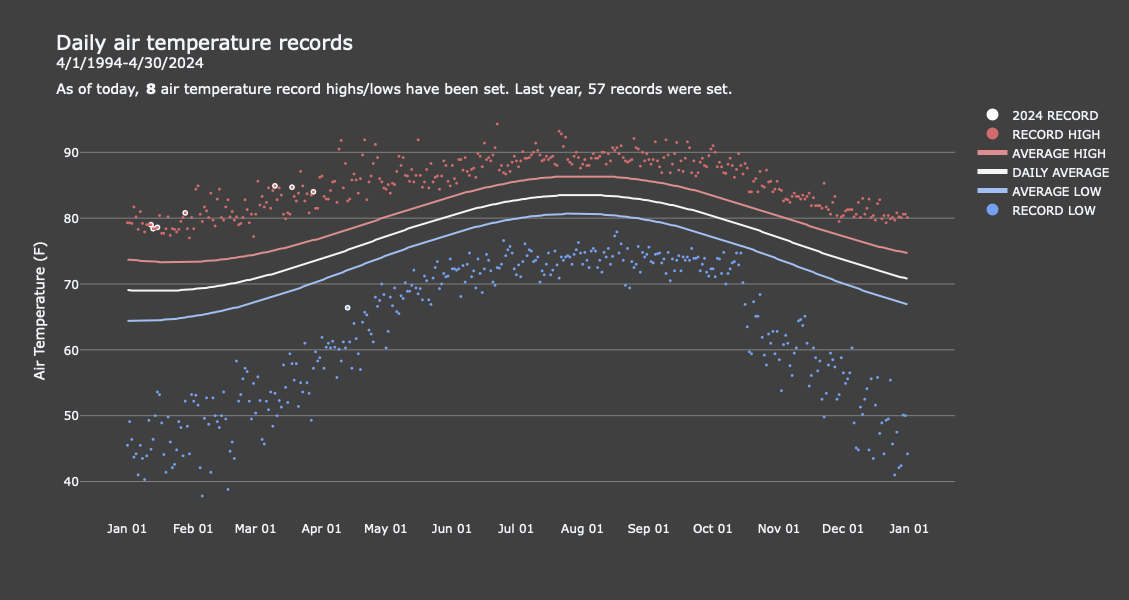

In [55]:
daily_climo(days, 'Air Temperature', scheme='mg')

In [18]:
    df = days.sel(variable='Air Temperature')
    thisYear = pd.to_datetime('today').year
    thisYearRecords = (df==thisYear).to_dataframe().drop('variable', axis=1).sum().sum()
    lastYearRecords = (df==thisYear-1).to_dataframe().drop('variable', axis=1).sum().sum()
    highRecords = df['Record High'].where(df['Record High Year'] == thisYear).to_dataframe()['Record High']
    highRecords.index = pd.to_datetime(highRecords.index+'-2020')
    lowRecords = df['Record Low'].where(df['Record Low Year'] == thisYear).to_dataframe()['Record Low']
    lowRecords.index = pd.to_datetime(lowRecords.index+'-2020')

In [56]:
days

<xarray.Dataset> Size: 103kB
Dimensions:                         (Date: 366, variable: 2)
Coordinates:
  * variable                        (variable) <U17 136B 'Air Temperature' 'W...
  * Date                            (Date) <U6 9kB '01-Jan' ... '31-Dec'
Data variables: (12/16)
    Daily Average                   (Date, variable) float64 6kB 71.5 ... 72.6
    Record High Daily Average       (Date, variable) float64 6kB 78.0 ... 80.5
    Record High Daily Average Year  (Date, variable) int64 6kB 2022 ... 2021
    Record Low Daily Average        (Date, variable) float64 6kB 54.4 ... 66.1
    Record Low Daily Average Year   (Date, variable) int64 6kB 2001 ... 2010
    Average High                    (Date, variable) float64 6kB 75.0 ... 73.9
    ...                              ...
    Average Low                     (Date, variable) float64 6kB 67.9 ... 71.4
    Highest Low                     (Date, variable) float64 6kB 76.8 ... 79.3
    Highest Low Year                (Date, variable) int64 6kB 2022 ... 2021
    Record Low                      (Date, variable) float64 6kB 45.5 ... 64.4
    Record Low Year                 (Date, variable) int64 6kB 2001 ... 2010
    Years                           (Date, variable) int64 6kB 23 24 ... 23 24
Attributes:
    datum:                         MHHW
    day_threshold:                 2
    hr_threshold:                  3
    last_updated:                  2024-05-25 10:00:00
    stationid:                     8723214
    stationname:                   Virginia Key, FL
    tz:                            lst
    unit_system:                   english
    Air Temperature units:         F
    Water Temperature units:       F
    Air Temperature data range:    ['1994-04-01', '2024-04-30']
    Water Temperature data range:  ['1994-04-01', '2024-04-30']

In [26]:
pd.isnull(highRecords.values[0])

True

In [33]:
[f'{thisYear} Record: {i}' if not pd.isnull(i) else '' for i in highRecords.values]

['',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '2024 Record: 79.0',
 '2024 Record: 78.4',
 '',
 '2024 Record: 78.6',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '2024 Record: 80.8',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '2024 Record: 84.9',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '2024 Record: 84.7',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '2024 Record: 84.0',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 

***